## 1 - Import Dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df=pd.read_csv(r"C:\Users\dell\Downloads\Cars Analysis\cars.csv")
df.head()

/kaggle/input/cars-dataset/cars.csv


,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [3]:
df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In [4]:
for clm in ['car name','brand','country','price','engine_capacity','cylinder','horse_power','top_speed','seats']:
    print(f'Name: {clm} dtype: {df[clm].dtype}\n')
    print(f'{df[clm].value_counts()}\n')
    print(('-' * 80) + '\n\n')

Name: car name dtype: object

car name
Mercedes-Benz C-Class 2022 C 300                          10
Fiat 500e 2021 La Prima                                    7
Porsche 911 2021 Carrera S Cabriolet                       7
Porsche 911 2021 Carrera 4S                                7
Kia Rio Sedan 2021 1.6L MPI                                7
                                                          ..
Jaguar F-Type Convertible 2021 2.0T R-Dynamic (300 PS)     1
Hyundai Kona 2021 1.6L T-GDI GLS Premium (AWD)             1
Chevrolet Trax 2021 1.8L Premier AWD                       1
Jaguar XF 2021 3.0 V6 SC R Sport                           1
Lamborghini Aventador Ultimae 2022 LP 780-4                1
Name: count, Length: 2546, dtype: int64

--------------------------------------------------------------------------------


Name: brand dtype: object

brand
mercedes-benz    560
audi             398
bmw              394
toyota           378
ford             323
                ... 
tata   

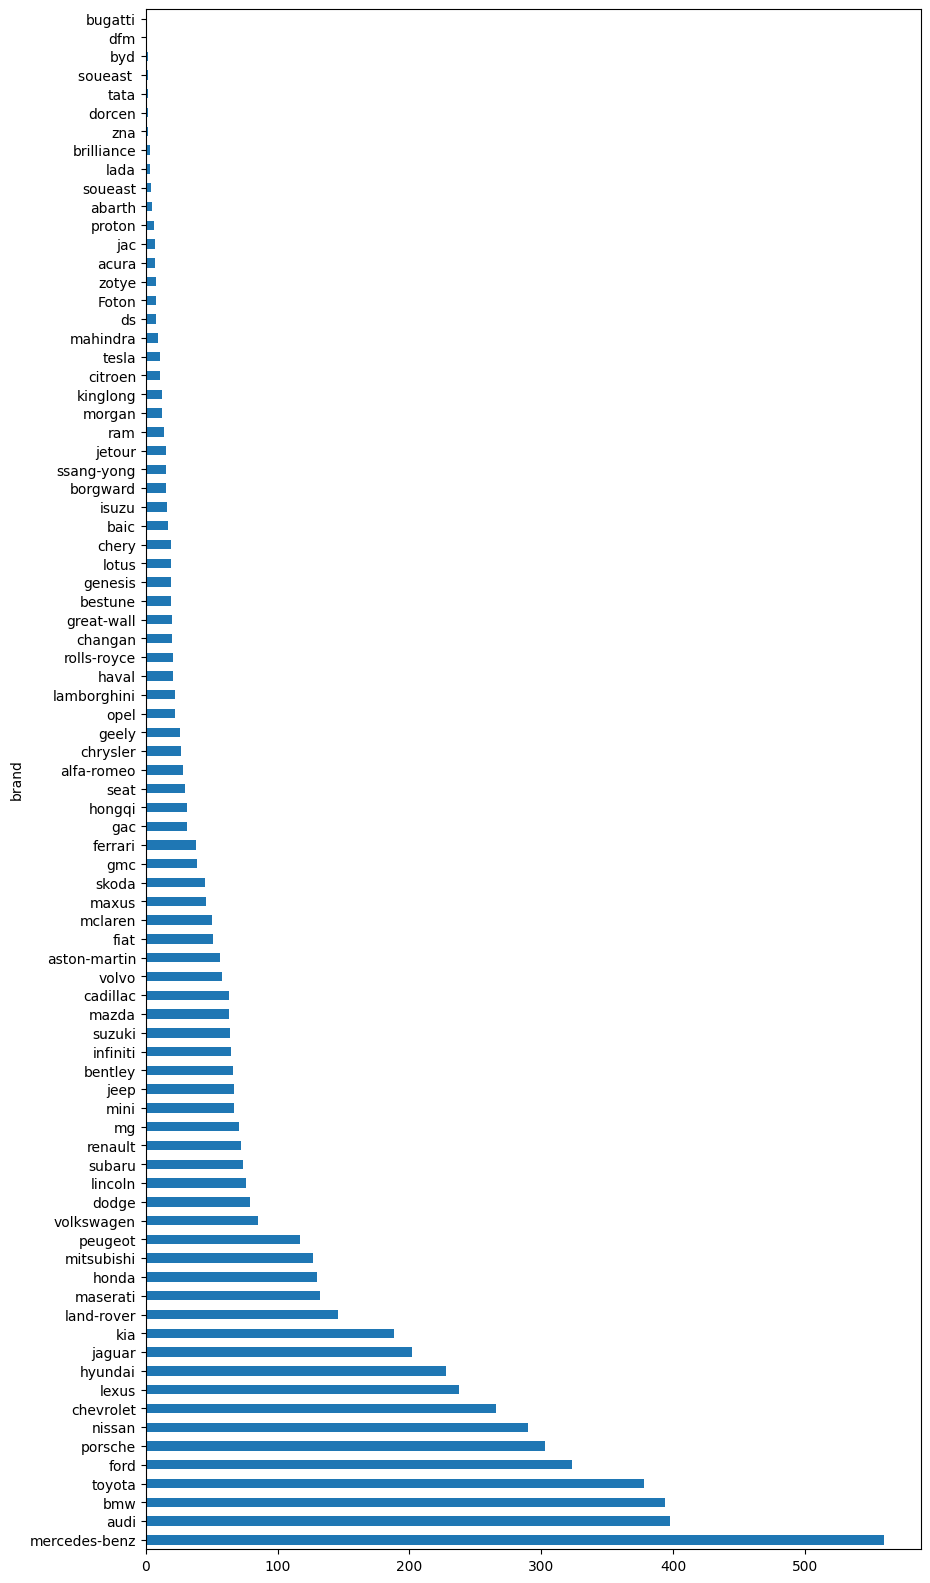

In [5]:
df['brand'].value_counts().plot.barh(figsize=(10,20));

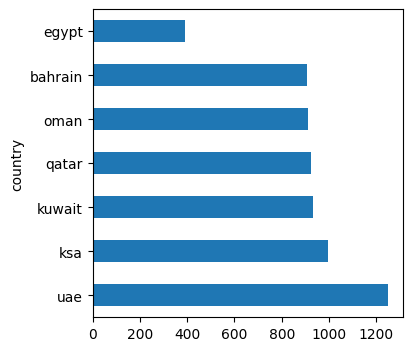

In [6]:
df['country'].value_counts().plot.barh(figsize=(4,4));

## 2- Data Cleaning

For each column in the dataset this are some reflection before start:
- **car name** and **brand**: no more action.
- **price**: create a custom function in order to extract price and currency. Where is it possible create price in euros and dollars
- **engine_capacity**, **cylinder**, **horse_power**, **top_speed**: simple conversion to float and set a limit
- **country**: simple re-mapping
- **seats**: ignore it

In [7]:
# This are some value I found symple by searching in the web

LIMIT_HOURSE_POWER = 1_500.0
LIMIT_KMH = 530.0
LIMIT_ENGINE_CAPACITY = 8.4
LIMIT_CYLINDER_NR = 16.0

In [8]:
def add_columns_by_function(df, clm, function, new_clms):
    new_data = df[clm].apply(function).apply(pd.Series)
    new_data.columns = new_clms
    df = pd.concat([df, new_data], axis=1)
    return df

In [9]:
def apply_price_adj(price):
    try:
        # Extract the currency code (first 3 characters)
        c = price[:3]
        # Extract the price string (everything after the currency code)
        price_str = price[4:].replace(',', '')  # Remove thousand separators
        
        # Convert price to float
        p = float(price_str)
        
        pe = p # Euros
        pd = p # Dollar

        # Currency conversion rates
        conversion_rates = {
            'AED': (0.24, 0.27),
            'KWD': (2.93, 3.28),
            'OMR': (2.32, 2.60),
            'BHD': (2.37, 2.65),
            'QAR': (0.27, 0.25),
            'SAR': (0.24, 0.27),
            'EGP': (0.018, 0.021)
        }

        # Adjust price based on currency
        if c in conversion_rates:
            pe, pd = [p * rate for rate in conversion_rates[c]]

        return [p, c, pe, pd]

    except (ValueError, IndexError) as e:
        # Return error values in a consistent format
        return [-1, 'ERR', -1, -1]

In [10]:
df_upd = df

# adjust price
df_upd = add_columns_by_function(df_upd, 'price', apply_price_adj, ['price_country', 'price_currency', 'price_euro', 'price_dollar'])

# adjust engine_capacity
df_upd['engine_capacity_float'] = pd.to_numeric(df_upd['engine_capacity'], errors='coerce')
df_upd['engine_capacity_l'] = np.where(df_upd['engine_capacity_float'] <= LIMIT_ENGINE_CAPACITY, df_upd['engine_capacity_float'], -1)

# adjust cylinder
df_upd['cylinder_float'] = pd.to_numeric(df_upd['cylinder'], errors='coerce')
df_upd['cylinder_nr'] = np.where(df_upd['cylinder_float'] <= LIMIT_CYLINDER_NR, df_upd['cylinder_float'], -1)
df_upd['is_eletric'] = np.where((df_upd['cylinder'] == 'N/A, Electric') | (df_upd['engine_capacity_l'] == 0), True, False)

# adjust horse_power
df_upd['horse_power_float'] = pd.to_numeric(df_upd['horse_power'], errors='coerce')
df_upd['horse_power_cv'] = np.where(df_upd['horse_power_float'] <= LIMIT_HOURSE_POWER, df_upd['horse_power_float'], -1)

# adjust top_speed
df_upd['top_speed_float'] = pd.to_numeric(df_upd['top_speed'], errors='coerce')
df_upd['top_speed_kmh'] = np.where(df_upd['top_speed_float'] <= LIMIT_KMH, df_upd['top_speed_float'], -1)

# adjust country
mapping = {
    'uae':'United Arab Emirates',
    'ksa':'Saudi Arabia',
    'kuwait':'Kuwait',
    'qatar':'Qatar', 
    'oman':'Oman',
    'bahrain': 'Bahrain',
    'egypt': 'Egypt'
}
df_upd = df_upd.replace(mapping)

df_upd.drop(['seats', 'engine_capacity_float', 'cylinder_float', 'horse_power_float', 'top_speed_float'], axis=1, inplace=True)

df_upd

,car name,price,engine_capacity,cylinder,horse_power,top_speed,brand,country,price_country,price_currency,price_euro,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,fiat,Saudi Arabia,-1.0,ERR,-1.0,-1.00,0.0,-1.0,True,-1.0,-1.0
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,peugeot,Saudi Arabia,140575.0,SAR,33738.0,37955.25,2.0,4.0,False,180.0,-1.0
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,suzuki,Saudi Arabia,98785.0,SAR,23708.4,26671.95,1.5,4.0,False,102.0,145.0
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,ford,Saudi Arabia,198000.0,SAR,47520.0,53460.00,2.3,4.0,False,420.0,-1.0
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,honda,Saudi Arabia,-1.0,ERR,-1.0,-1.00,1.8,4.0,False,140.0,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,Bentley Mulsanne 2021 6.75L V8 Extended Wheelbase,DISCONTINUED,6.8,8,505,296,bentley,United Arab Emirates,-1.0,ERR,-1.0,-1.00,6.8,8.0,False,505.0,296.0
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,"AED 1,766,100",4.0,8,25,800,ferrari,United Arab Emirates,1766100.0,AED,423864.0,476847.00,4.0,8.0,False,25.0,-1.0
6305,Rolls Royce Wraith 2021 6.6L Base,"AED 1,400,000",6.6,12,624,250,rolls-royce,United Arab Emirates,1400000.0,AED,336000.0,378000.00,6.6,12.0,False,624.0,250.0
6306,Lamborghini Aventador S 2021 6.5L V12 Coupe,"AED 1,650,000",6.5,NaN,740,350,lamborghini,United Arab Emirates,1650000.0,AED,396000.0,445500.00,6.5,-1.0,False,740.0,350.0


In [11]:
# create car_type feature
bins_car_type = [-100, 0, 160, 240, 300, 550]
labels_car_type = ['ERR', 'City Car', 'SUV', 'Super Car', 'Hyper Car']
df_upd['car_type'] = pd.cut(df_upd['top_speed_kmh'], bins=bins_car_type, labels=labels_car_type)

# create car_engine_type feature
bins_car_engine_type = [-100, -1, 0, 1.5, 3.5, 100]
labels_car_engine_type = ['ERR', 'Eletric', '0 - 1.5', '1.5 - 3.5', '> 3.5']
df_upd['car_engine_type'] = pd.cut(df_upd['engine_capacity_l'], bins=bins_car_engine_type, labels=labels_car_engine_type)

df_upd

,car name,price,engine_capacity,cylinder,horse_power,top_speed,brand,country,price_country,price_currency,price_euro,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh,car_type,car_engine_type
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,fiat,Saudi Arabia,-1.0,ERR,-1.0,-1.00,0.0,-1.0,True,-1.0,-1.0,ERR,Eletric
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,peugeot,Saudi Arabia,140575.0,SAR,33738.0,37955.25,2.0,4.0,False,180.0,-1.0,ERR,1.5 - 3.5
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,suzuki,Saudi Arabia,98785.0,SAR,23708.4,26671.95,1.5,4.0,False,102.0,145.0,City Car,0 - 1.5
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,ford,Saudi Arabia,198000.0,SAR,47520.0,53460.00,2.3,4.0,False,420.0,-1.0,ERR,1.5 - 3.5
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,honda,Saudi Arabia,-1.0,ERR,-1.0,-1.00,1.8,4.0,False,140.0,190.0,SUV,1.5 - 3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,Bentley Mulsanne 2021 6.75L V8 Extended Wheelbase,DISCONTINUED,6.8,8,505,296,bentley,United Arab Emirates,-1.0,ERR,-1.0,-1.00,6.8,8.0,False,505.0,296.0,Super Car,> 3.5
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,"AED 1,766,100",4.0,8,25,800,ferrari,United Arab Emirates,1766100.0,AED,423864.0,476847.00,4.0,8.0,False,25.0,-1.0,ERR,> 3.5
6305,Rolls Royce Wraith 2021 6.6L Base,"AED 1,400,000",6.6,12,624,250,rolls-royce,United Arab Emirates,1400000.0,AED,336000.0,378000.00,6.6,12.0,False,624.0,250.0,Super Car,> 3.5
6306,Lamborghini Aventador S 2021 6.5L V12 Coupe,"AED 1,650,000",6.5,NaN,740,350,lamborghini,United Arab Emirates,1650000.0,AED,396000.0,445500.00,6.5,-1.0,False,740.0,350.0,Hyper Car,> 3.5


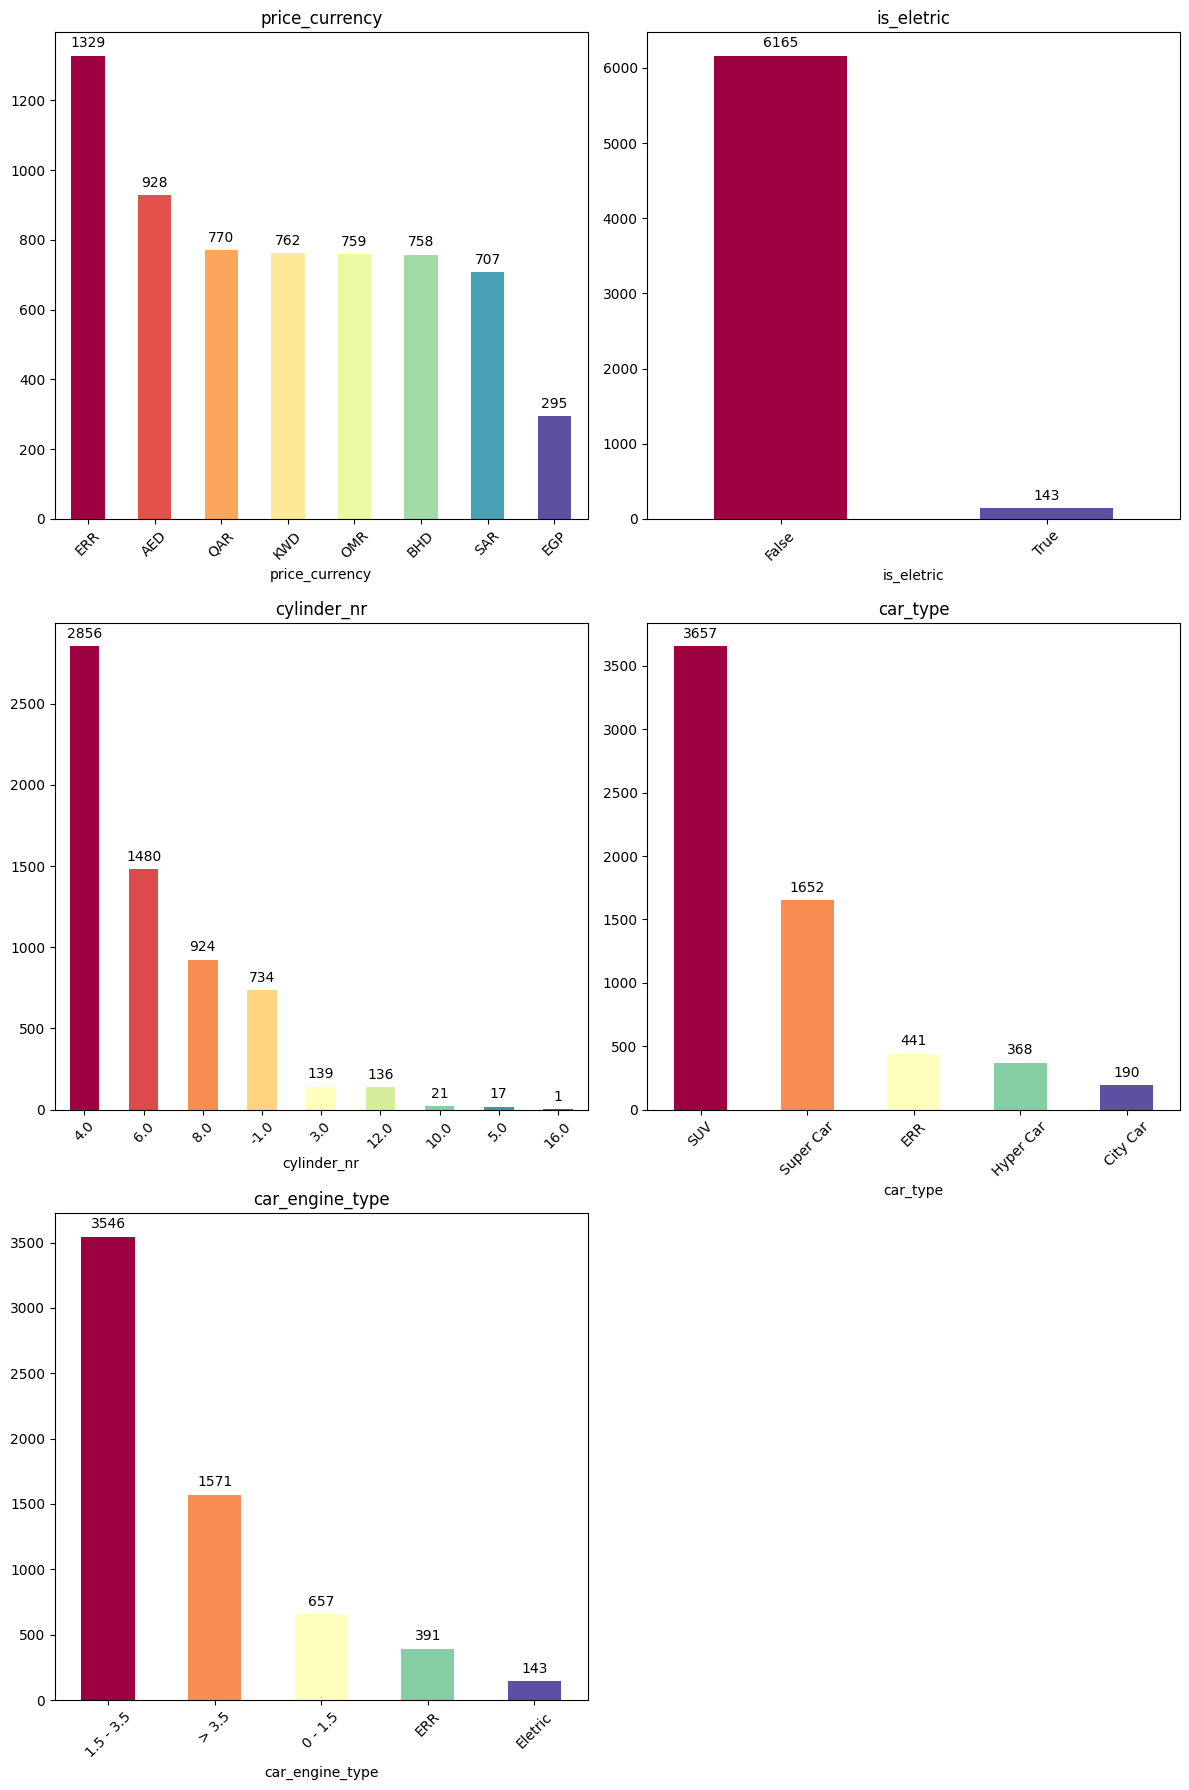

In [12]:
new_stat_clm = ['price_currency', 'is_eletric','cylinder_nr', 'car_type', 'car_engine_type']

n_cols = 2
n_rows = (len(new_stat_clm) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols)

axes = axes.flatten()

for ax, clm in zip(axes, new_stat_clm):
    value_counts = df_upd[clm].value_counts()
    
    cmap = sns.color_palette("Spectral", as_cmap=True)
    colors = [cmap(i) for i in np.linspace(0, 1, len(value_counts))]
    
    value_counts.plot.bar(ax=ax, color=colors, figsize=(12, 18))
    
    ax.set_title(f'{clm}')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 9), 
            textcoords='offset points', 
            fontsize=10
        )

for ax in axes[len(new_stat_clm):]:
    ax.remove()
    
plt.tight_layout()
plt.show()

Remove all the errors from data:

In [13]:
dataset = df_upd

cond_pc = dataset['price_currency'] == 'ERR'
cond_cap = dataset['engine_capacity_l'] == -1
cond_cyl = dataset['cylinder_nr'] == -1
cond_pow = dataset['horse_power_cv'] == -1
cond_ts = dataset['top_speed_kmh'] == -1

dataset = dataset[~(cond_pc | cond_cap | cond_cyl | cond_pow | cond_ts)]

dataset.describe()

,price_country,price_euro,price_dollar,engine_capacity_l,cylinder_nr,horse_power_cv,top_speed_kmh
count,3.904000e+03,3.904000e+03,3.904000e+03,3904.000000,3904.000000,3904.000000,3904.000000
mean,1.522130e+05,6.605515e+04,7.194196e+04,2.880558,5.375512,283.979508,222.432633
std,3.290803e+05,8.834657e+04,9.742840e+04,1.321436,1.908052,150.241202,42.323136
min,2.899000e+03,6.960000e+03,7.800000e+03,0.000000,3.000000,75.000000,120.000000
25%,1.800000e+04,2.394000e+04,2.624000e+04,2.000000,4.000000,164.000000,186.500000
50%,6.525000e+04,4.336400e+04,4.725000e+04,2.500000,4.000000,250.000000,219.000000
75%,1.749000e+05,8.107050e+04,8.738250e+04,3.600000,6.000000,365.500000,250.000000
max,1.331480e+07,3.195552e+06,3.594996e+06,8.000000,16.000000,1479.000000,350.000000


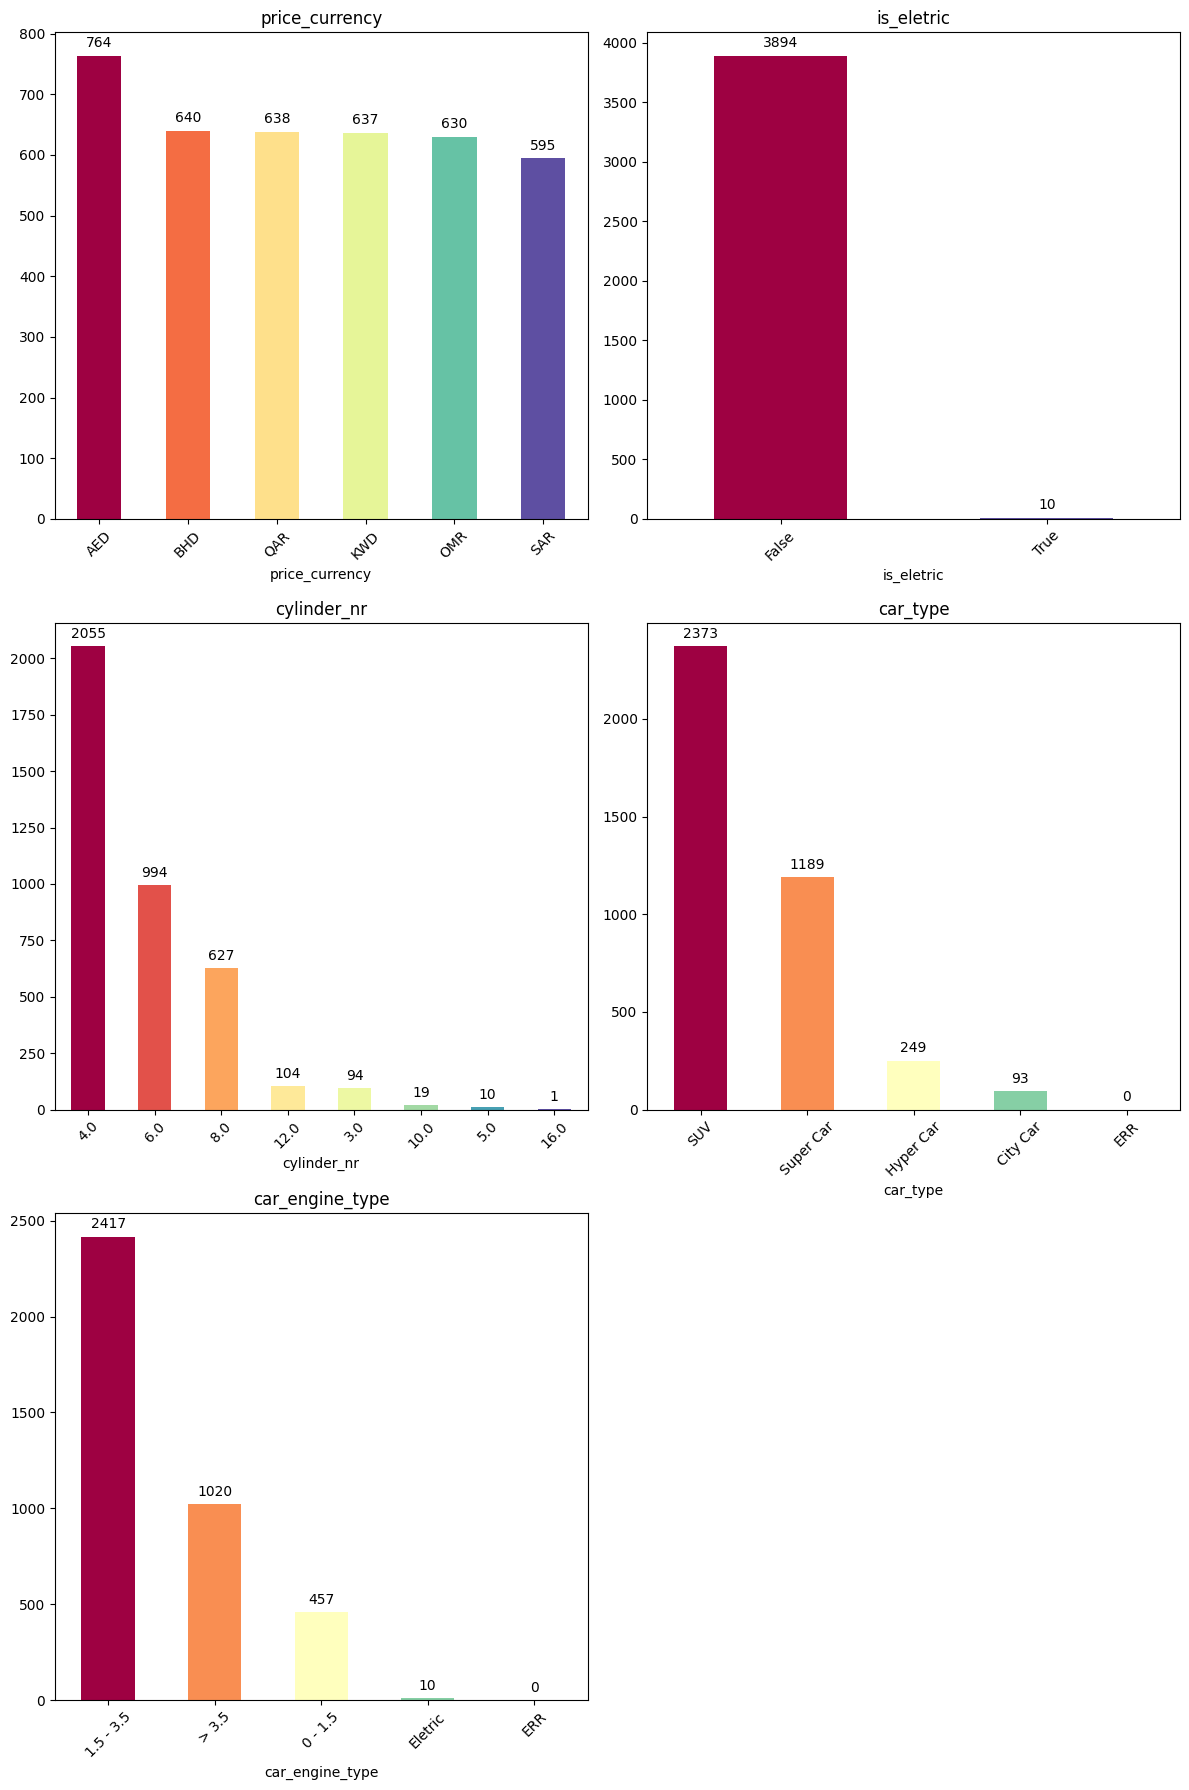

In [14]:
fig, axes = plt.subplots(n_rows, n_cols)

axes = axes.flatten()

for ax, clm in zip(axes, new_stat_clm):
    value_counts = dataset[clm].value_counts()
    
    cmap = sns.color_palette("Spectral", as_cmap=True)
    colors = [cmap(i) for i in np.linspace(0, 1, len(value_counts))]
    
    value_counts.plot.bar(ax=ax, color=colors, figsize=(12, 18))
    
    ax.set_title(f'{clm}')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 9), 
            textcoords='offset points', 
            fontsize=10
        )

for ax in axes[len(new_stat_clm):]:
    ax.remove()
    
plt.tight_layout()
plt.show()

## 3 - Exploratory data analysis (EDA) + Interactivity

In [15]:
from ipywidgets import interact
from IPython.display import display

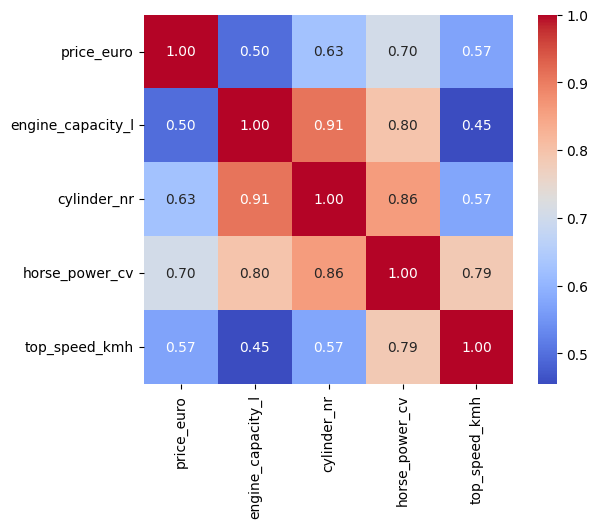

In [16]:
brands = dataset['brand'].unique()
f_num = ['price_euro','engine_capacity_l', 'cylinder_nr','horse_power_cv','top_speed_kmh']
dataset_corr = dataset[f_num]
sns.heatmap(dataset_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True);

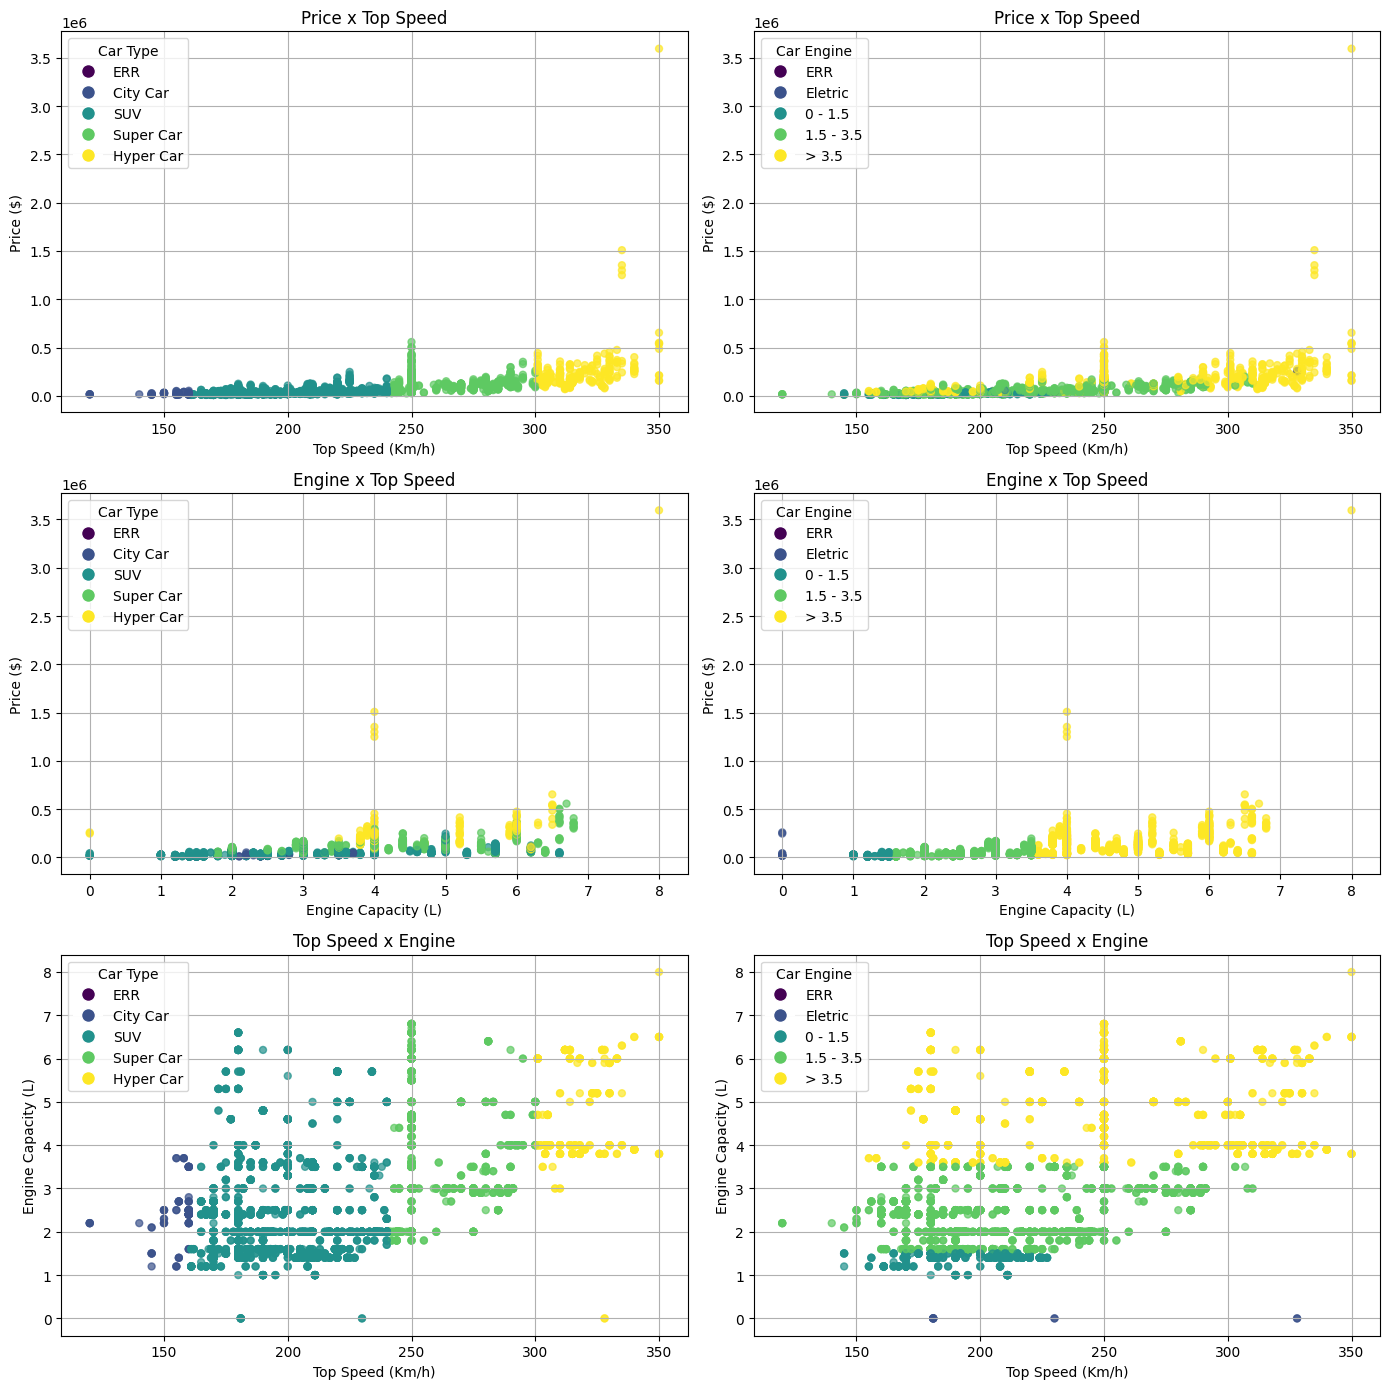

In [17]:
car_type_cmap = dataset['car_type'].astype('category').cat.codes
car_engine_cmap = dataset['car_engine_type'].astype('category').cat.codes

car_type_lbls = dataset['car_type'].astype('category').cat.categories
car_engine_lbls = dataset['car_engine_type'].astype('category').cat.categories

viridis = plt.colormaps['viridis'].resampled(len(car_type_lbls))
colors_car_type = viridis(np.linspace(0, 1, len(car_type_lbls)))

viridis_engine = plt.colormaps['viridis'].resampled(len(car_engine_lbls))
colors_car_engine = viridis_engine(np.linspace(0, 1, len(car_engine_lbls)))

car_type_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=colors_car_type[i], markersize=10)
                    for i in range(len(car_type_lbls))]

car_engine_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=colors_car_engine[i], markersize=10)
                      for i in range(len(car_engine_lbls))]

configurations = [
    {
        'x': {
            'label': 'Top Speed (Km/h)',
            'column': 'top_speed_kmh'
        },
        'y': {
            'label': 'Price ($)',
            'column': 'price_dollar'
        },
        'title':'Price x Top Speed'
    },
    {
        'x': {
            'label': 'Engine Capacity (L)',
            'column': 'engine_capacity_l'
        },
        'y': {
            'label': 'Price ($)',
            'column': 'price_dollar'
        },
        'title':'Engine x Top Speed'
    },
    {
        'x': {
            'label': 'Top Speed (Km/h)',
            'column': 'top_speed_kmh'
        },
        'y': {
            'label': 'Engine Capacity (L)',
            'column': 'engine_capacity_l'
        },
        'title':'Top Speed x Engine'
    }
]

fig, axes = plt.subplots(len(configurations), 2, figsize=(14, 14))

for ax, c in zip(axes, configurations):
    ax[0].scatter(dataset[c['x']['column']], dataset[c['y']['column']], 
                             c=[colors_car_type[i] for i in car_type_cmap], marker='.', 
                             s=100, alpha=0.7)
    
    ax[0].set_xlabel(c['x']['label'])
    ax[0].set_xscale('linear')
    ax[0].set_ylabel(c['y']['label'])
    ax[0].set_yscale('linear')
    ax[0].set_title(c['title'])
    ax[0].grid(True)
    ax[0].legend(car_type_handles, car_type_lbls, title="Car Type", loc='upper left')
    
    ax[1].scatter(dataset[c['x']['column']], dataset[c['y']['column']], 
                             c=[colors_car_engine[i] for i in car_engine_cmap], marker='.', 
                             s=100, alpha=0.7)
    
    ax[1].set_xlabel(c['x']['label'])
    ax[1].set_xscale('linear')
    ax[1].set_ylabel(c['y']['label'])
    ax[1].set_yscale('linear')
    ax[1].set_title(c['title'])
    ax[1].grid(True)
    ax[1].legend(car_engine_handles, car_engine_lbls, title="Car Engine", loc='upper left')

plt.tight_layout()
plt.show()

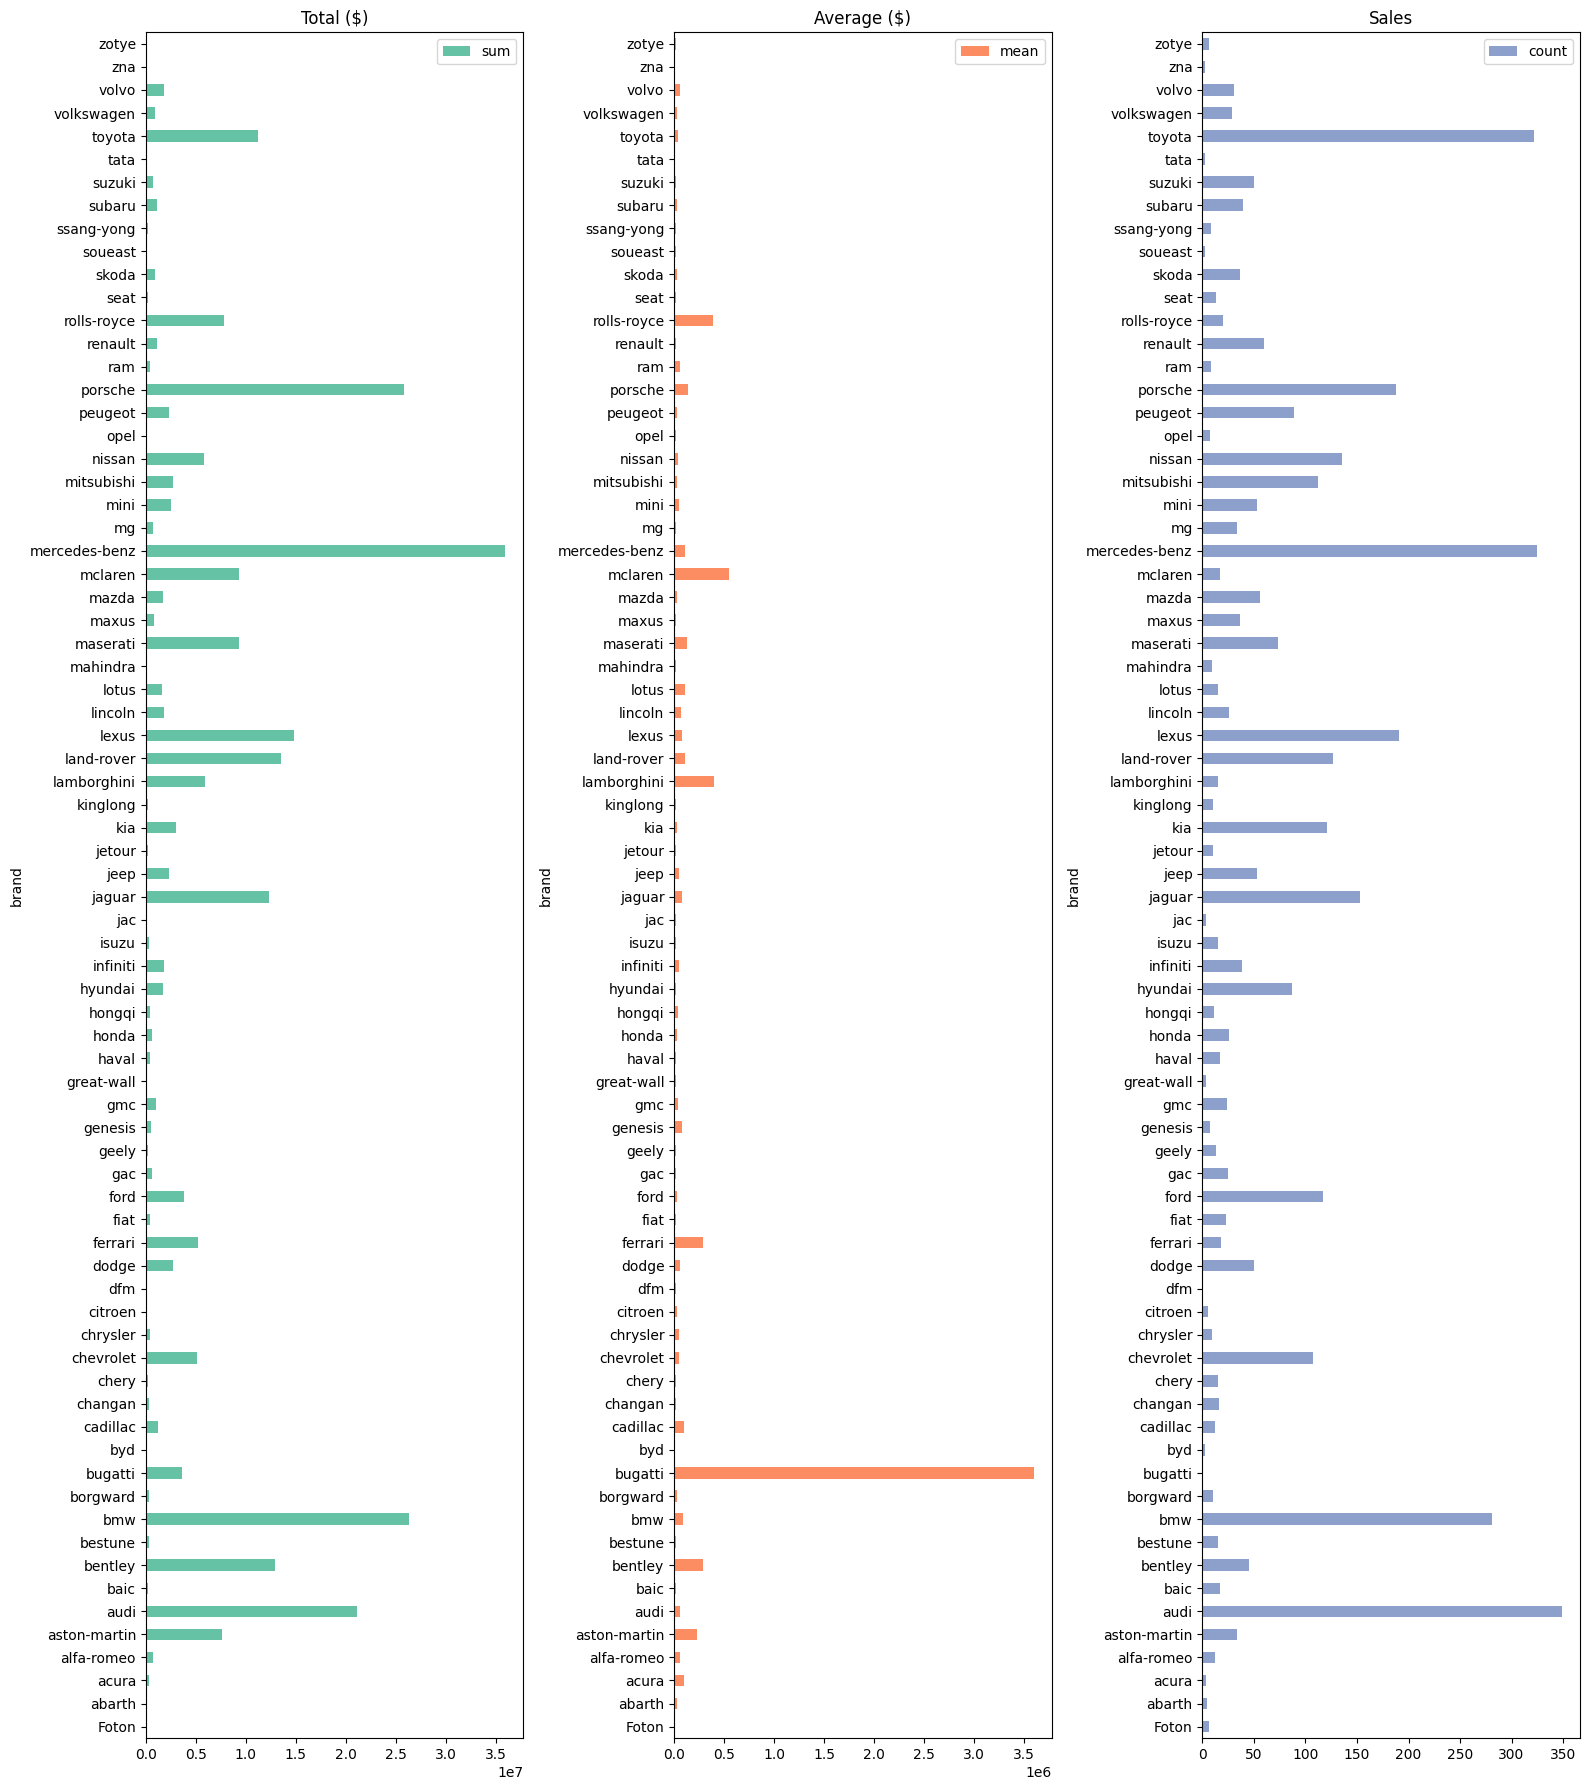

In [18]:
palette = sns.color_palette("Set2", 3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 18))

dataset.groupby(['brand'])['price_dollar'].agg(['sum']).plot.barh(ax=axs[0], color=palette[0])
axs[0].set_title('Total ($)')

dataset.groupby(['brand'])['price_dollar'].agg(['mean']).plot.barh(ax=axs[1], color=palette[1])
axs[1].set_title('Average ($)')

dataset.groupby(['brand'])['price_dollar'].agg(['count']).plot.barh(ax=axs[2], color=palette[2])
axs[2].set_title('Sales')

plt.tight_layout()
plt.show()

In [19]:
palette = sns.color_palette("Set2", 3)

@interact(bn1 = brands, bn2 = brands, bn3 = brands, bn4 = brands)
def get_brands_statistic(bn1, bn2, bn3, bn4):
    b = [bn1, bn2, bn3, bn4]
    
    ds_brand = dataset[dataset['brand'].isin(b)]
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

    ds_brand.groupby(['brand'])['price_dollar'].agg(['sum']).plot.barh(ax=axs[0],color=palette[0])
    axs[0].set_title('Total ($)')

    ds_brand.groupby(['brand'])['price_dollar'].agg(['mean']).plot.barh(ax=axs[1],color=palette[1])
    axs[1].set_title('Average ($)')

    ds_brand.groupby(['brand'])['price_dollar'].agg(['count']).plot.barh(ax=axs[2],color=palette[2])
    axs[2].set_title('Sales')

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='bn1', options=('suzuki', 'honda', 'peugeot', 'renault', 'gac', 'as…